#1. Data importing and preprocessing

*   Import cleaned data
*   Required libraries are imported
*   Check for GPU availability to be used by the model
*   Data split into features (X) and target (y)
*   Data split into teain_validation and test
*   Feature scaling by StandardScaler



In [3]:
!pip install keras-tuner
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from keras_tuner import RandomSearch, HyperParameters
from keras import layers, Sequential
import os

# check for GPU usage
print("GPU Available to use:", tf.config.list_physical_devices('GPU'))

#import cleaned data storred in the previous notebook (01_Data_cleaning_inspection)
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/data/interim/cleaned_data.parquet'
df = pd.read_parquet(file_path)

# Target (y) and independent variables (X)
y = df['Demand Forecast']
X = df.drop(columns = ['Demand Forecast'])

# Display five rows of X and y
print("*************************************")
print("First five rows of X and y:")
print("*************************************")
print(f"First five rows of X:\n {X.head(5)}")
print("*************************************")
print(f"\nFirst five rows of y:\n {y.head(5)}")
print("*************************************")
#split X and y into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00
GPU Available to use: []
Mounted at /content/drive
*************************************
First five rows of X and y:
*************************************
First five rows of X:
    Inventory Level  Units Sold  Units Ordered  Price  Discount  \
0              231         127             55  33.50        20   
1              204         150             66  63.01        20   
2              102          65             51  27.99        10   
3              469          61            164  32.72        10   
4              166          14            135  73.64         0   

   Holiday/Promotion  Competitor Pricing  Store ID_S001  Store ID_S002  \
0                  0               29.69            1.0            0.0   
1                  0               66.16            1.0            0.0   
2                  1               31.32            1.0            0.0   
3                  1               34.74         

**Results of above cell show that the data imported properly**

#2. Model building - TensorFlow

In [4]:
def model_build(hp):
    model = Sequential()

    # Input layer with proper shape
    model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))  # Use your actual input dimension

    # Tune number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tune number of units in each layer
        hp_units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        model.add(layers.Dense(units=hp_units, activation='relu'))
        # Tune dropout rate
        if hp.Boolean(f'dropout_{i}'):
            model.add(layers.Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(1))  # For regression

    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model

# Initialize tuner
tuner = RandomSearch(
    model_build,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='Demand_Forecast'
)


# Search for the best model
tuner.search(X_train_scaled, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])

# Get the best model
best_model = tuner.get_best_models(1)[0]

# Train final model
history = best_model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, callbacks=[
    keras.callbacks.EarlyStopping(patience=10)
])

# Evaluate on test set
y_pred = best_model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("*************************************")
print(f"\n Final Evaluation:")
print("*************************************")
print(f"*Mean Squared Error (MSE): {mse:.2f}")
print("*************************************")
print(f"*R-squared (R²): {r2:.2f}")
print("*************************************")

Trial 10 Complete [00h 00m 35s]
val_mae: 11.167926788330078

Best val_mae So Far: 7.728631019592285
Total elapsed time: 00h 15m 31s
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 96.5812 - mae: 8.1424 - val_loss: 85.1180 - val_mae: 7.8500
Epoch 2/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 97.2747 - mae: 8.1811 - val_loss: 83.0307 - val_mae: 7.7768
Epoch 3/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 97.2103 - mae: 8.1775 - val_loss: 82.5364 - val_mae: 7.7719
Epoch 4/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 95.9238 - mae: 8.1125 - val_loss: 81.8570 - val_mae: 7.7419
Epoch 5/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 95.6307 - mae: 8.1060 - val_loss: 81.3262 - val_mae: 7.7114
Epoch 6/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 96.2873 - mae: 8.1371 - val_loss: 83.4812 - val_mae: 7.8094
Epoch 7/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 95.4460 - mae: 8.1055 - val_loss: 81.7139 - val_mae: 7.7261
Epoch 8/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 95.1676 - mae: 8.0993 - val_loss: 81.0486 - val_mae: 7.7242
Epoch 9/100
1462/1462 ━━━━━━

# 3. Performance analysis of the model by below plots
*   Actual vs predicted
*   Residual error
*   Convergence curve


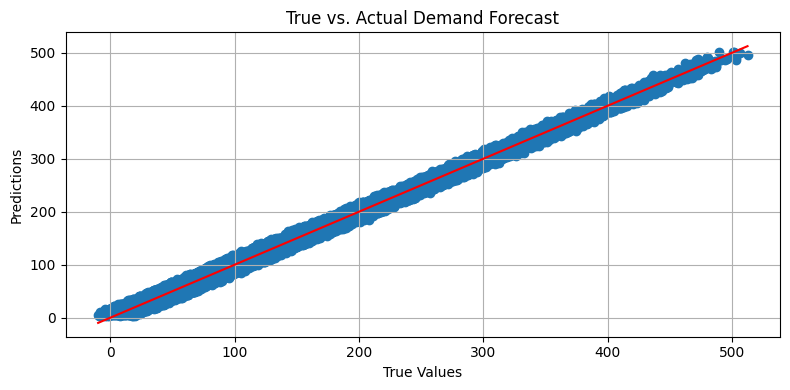

/tmp/ipython-input-3420489471.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


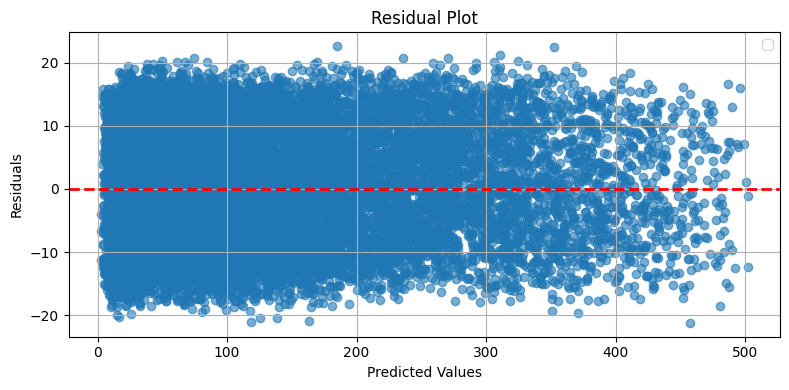

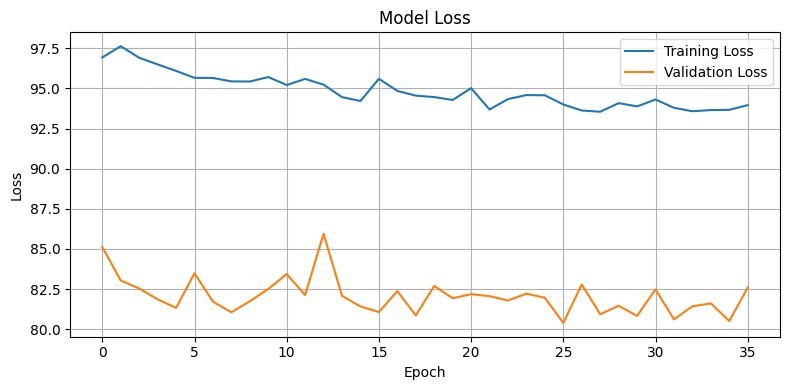

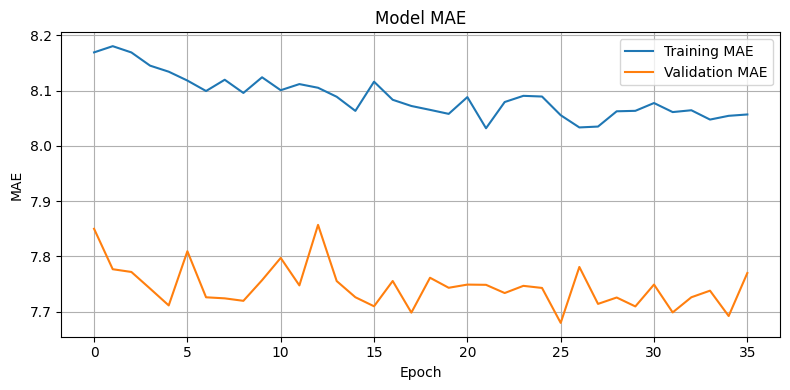

In [11]:
os.makedirs('plots', exist_ok=True)
# Plot predictions (actual/predicted) and residual
#(actual/predicted) plot
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs. Actual Demand Forecast")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/plots/True_Actual_Demand_Forecast_tf.png')
plt.show()
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/plots/Residual_Plot_tf.png')
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/plots/training_validation_loss_tf.png')
plt.show()

#Plot training & validation MAE
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/plots/Convergence_Curve_tf.png')
plt.show()



**According to plots and results of the model, it has been trained well.**


#6. Save the best model

In [15]:
# Save your trained model
import joblib
file_path2 = '/content/drive/MyDrive/Colab Notebooks/DL_model_tensorflow.pkl'
joblib.dump(best_model, file_path2)
print("Model saved successfully!")

Model saved successfully!
